# 🎬 Movie Genre Classification Using NLP & Machine Learning

This notebook demonstrates how to classify movie genres based on plot summaries using:

- TF-IDF vectorization
- Logistic Regression classifier
- Multi-label text classification

Dataset: `movies_metadata.csv`


In [ ]:
# Install & Import Libraries (Code)
!pip install pandas scikit-learn numpy

In [1]:
import pandas as pd
import numpy as np
import ast

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report


In [2]:
# Load Dataset (Code)
data = pd.read_csv("../data/movies_metadata.csv", dtype={"id": str})
data.head()


,adult,belongs_to_collection,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,30-10-1995,373554033,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,15-12-1995,262797249,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.712900,...,22-12-1995,0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,22-12-1995,81452156,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,10-02-1995,76578911,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173


In [3]:
# Keep Required Columns
data = data[['overview', 'genres']]
data.dropna(subset=['overview', 'genres'], inplace=True)
data.head()


,overview,genres
0,"Led by Woody, Andy's toys live happily in his ...","[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,When siblings Judy and Peter discover an encha...,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,A family wedding reignites the ancient feud be...,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,"Cheated on, mistreated and stepped on, the wom...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,Just when George Banks has recovered from his ...,"[{'id': 35, 'name': 'Comedy'}]"


In [4]:
# Parse Genre Strings

def parse_genres(x):
    try:
        genres_list = ast.literal_eval(x)
        return [g['name'] for g in genres_list if 'name' in g]
    except:
        return []

data['genres'] = data['genres'].apply(parse_genres)
data = data[data['genres'].map(len) > 0]
data.head()


,overview,genres
0,"Led by Woody, Andy's toys live happily in his ...","[Animation, Comedy, Family]"
1,When siblings Judy and Peter discover an encha...,"[Adventure, Fantasy, Family]"
2,A family wedding reignites the ancient feud be...,"[Romance, Comedy]"
3,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]"
4,Just when George Banks has recovered from his ...,[Comedy]


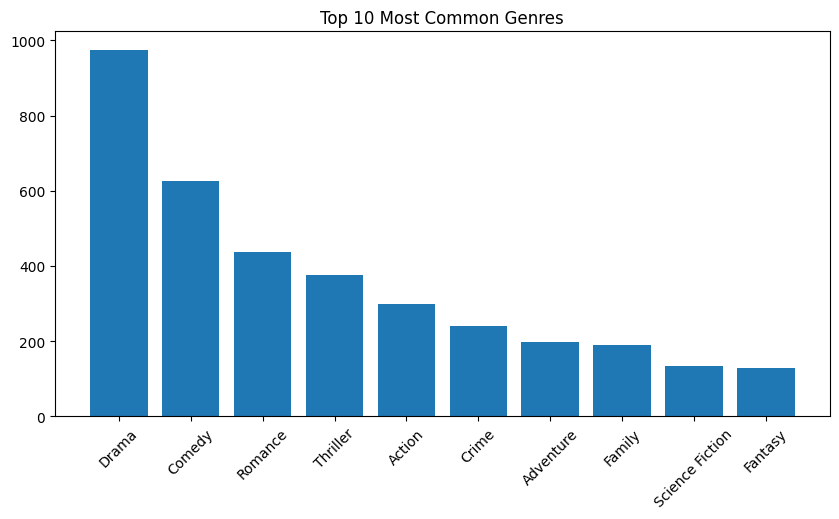

In [5]:
# Visualize Genre Counts

from collections import Counter
import matplotlib.pyplot as plt

genre_counts = Counter([genre for sub in data['genres'] for genre in sub])
top_genres = dict(genre_counts.most_common(10))

plt.figure(figsize=(10,5))
plt.bar(top_genres.keys(), top_genres.values())
plt.xticks(rotation=45)
plt.title("Top 10 Most Common Genres")
plt.show()


In [6]:
# Prepare Data for ML

X = data['overview']
y = data['genres']

# Multi-label encoding
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [7]:
# TF-IDF Vectorization

tfidf = TfidfVectorizer(stop_words="english", max_features=5000, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

X_train_tfidf.shape


(1366, 5000)

In [8]:
# Train Model

model = OneVsRestClassifier(LogisticRegression(max_iter=1200, class_weight="balanced"))
model.fit(X_train_tfidf, Y_train)


OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1200))

In [9]:
# Model Evaluation

Y_pred = model.predict(X_test_tfidf)

subset_accuracy = accuracy_score(Y_test, Y_pred)
macro_f1 = f1_score(Y_test, Y_pred, average="macro")

print("Subset Accuracy:", subset_accuracy)
print("Macro F1 Score:", macro_f1)

print("\nClassification Report:\n")
print(classification_report(Y_test, Y_pred, target_names=mlb.classes_))


Subset Accuracy: 0.11403508771929824
Macro F1 Score: 0.3681561262577285

Classification Report:

                 precision    recall  f1-score   support

         Action       0.53      0.53      0.53        58
      Adventure       0.44      0.28      0.34        39
      Animation       0.00      0.00      0.00         6
         Comedy       0.56      0.56      0.56       130
          Crime       0.48      0.50      0.49        44
    Documentary       0.80      0.24      0.36        17
          Drama       0.68      0.66      0.67       189
         Family       0.60      0.43      0.50        42
        Fantasy       0.50      0.17      0.25        30
        Foreign       0.00      0.00      0.00         8
        History       0.67      0.50      0.57         8
         Horror       0.71      0.16      0.26        31
          Music       1.00      0.14      0.25        14
        Mystery       0.57      0.28      0.37        29
        Romance       0.55      0.48      0.51 

C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Prediction Function

def predict_genre(text):
    vector = tfidf.transform([text])
    prediction = model.predict(vector)[0]
    return [genre for genre, val in zip(mlb.classes_, prediction) if val == 1]


In [11]:
# Test With Custom Input

test_plot = "A young hero travels through space to defeat an evil empire and save the galaxy."
print("Plot:", test_plot)
print("Predicted Genres:", predict_genre(test_plot))


Plot: A young hero travels through space to defeat an evil empire and save the galaxy.
Predicted Genres: ['Action', 'Adventure', 'Family', 'Fantasy', 'Science Fiction']


## 📌 Conclusion

- We successfully built a **multi-label movie genre classifier**.
- Machine learning model: **Logistic Regression + OneVsRest**
- Feature extraction: **TF-IDF**
- Limitations:
  - Dataset is small and imbalanced
  - Many rare genre combinations make prediction difficult

### 🚀 Future Improvements:
- Use Transformer models (BERT, DistilBERT)
- Increase dataset size
- Use word embeddings (Word2Vec, GloVe)
- Apply oversampling (SMOTE)

---

Thanks for exploring this machine learning project!
